# ㅎㅇㅎㅇ

In [2]:
import os 
import pandas as pd
import numpy as np
import time
import datetime
import zipfile
from tqdm import tqdm
import urllib, json
import folium
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


# import operator
import re,  math  
import glob, sys
import platform

# donwload
import os 
import os.path as path
import requests
from multiprocessing import Pool
from functools import partial

In [3]:
pathName = f'C:/Users/pleasure/학과공모전/'
dirPath = os.listdir(pathName)

In [4]:
dirPath

['.ipynb_checkpoints',
 '20201029황혼까지 분석.ipynb',
 '20201101 학과공모전.ipynb',
 'DataMiners',
 'index data 만지기.ipynb',
 'KT_data_20200717',
 'pivot_diff_월끼리.ipynb',
 'seoul_municipalities_geo.json',
 '로밍 19,20 02~08',
 '시각화 남들이 만들어놓은 함수 모음집.ipynb',
 '유동인구 19,20 03~08',
 '통화 20 02~08']

In [5]:
#그래프 한글 나오게 하기
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [6]:
# 제공 받은 데이터 로드
#card_origin  = pd.read_csv( pathName + dirPath[5] +"/" + "card_20200717.csv") #데이터 수정 필요
#delivery     = pd.read_csv( pathName + dirPath[5] +"/" + "delivery.csv")
#fpopl_origin = pd.read_csv( pathName + dirPath[5] +"/" + "fpopl.csv")
#policy       = pd.read_csv( pathName + dirPath[3] +"/" + "policy_edit.csv") # 제공 policy 기반 
#Time         = pd.read_csv( pathName + dirPath[5] +"/" + "COVID_19/Time.csv")
#dong_df      = pd.read_csv( pathName + dirPath[5] +"/" + "adstrd_master.csv") #데이터 수정 필요
index_df      = pd.read_csv( pathName + dirPath[5] +"/" + "index.csv") #데이터 수정 필요

# 지도 그래프 전처리

In [7]:
#지도를 그리기 위한 서울 지도 json파일
url = 'https://raw.github.com/PinkWink/DataScience/master/data/02.%20skorea_municipalities_geo_simple.json'
with urllib.request.urlopen(url) as fp:
    gu_geojson = json.loads(fp.read())

In [8]:
#지도그리는 함수
def plot_gu_map(df, value_col, geojson=gu_geojson, legend_name=None, map_title=None):
    if legend_name is None:
        legend_name = value_col

    if map_title is None:
        map_title = f'Seoul Choropleth Map of {value_col}' if legend_name is None \
    else f'Seoul Choropleth Map of {legend_name}'

    # 지도 경계 json 파일에 자치구별 value 정보 추가
    for idx, gu_dict in enumerate(geojson['features']):
        gu_nm = gu_dict['id']
        value = df.loc[df.자치구명==gu_nm, value_col].iloc[0]
        txt = f'{gu_nm}<br>{value:.3f}'
        geojson['features'][idx]['properties']['tooltip1'] = txt


    print(f'\n\n>>> 서울시 자치구별 단계구분도 (기준 : {value_col})')

    m = folium.Map(location=[37.562225, 126.978555], zoom_start=11, tiles='Stamen Toner')
    choropleth = folium.Choropleth(
      geo_data = geojson,
      data = df,
      columns = ['자치구명', value_col],
      fill_color = 'Oranges',
      key_on = 'feature.id',
      fill_opacity=0.9,
      line_opacity=1,
      legend_name=legend_name
    ).add_to(m)
    choropleth.geojson.add_child( folium.features.GeoJsonTooltip(['tooltip1'], labels=False))

    title_html = f'<h3 align="center" style="font-size:20px"><b>{map_title}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))
    folium.LayerControl().add_to(m)

    return m

In [9]:
#나이와 성별 all고정 묶어서 하나로 만듬
index_all = index_df[(index_df["age"] == "all") & (index_df["gender"] == "all")]

In [10]:
#시군구 all인 행 제외
index_all = index_all.drop(index_all[index_all["sigungu"] == "all"].index)

In [11]:
index_all["sigungu"].value_counts()

노원구     287
송파구     286
은평구     272
관악구     272
중랑구     272
서대문구    272
마포구     272
양천구     272
성북구     272
종로구     272
동작구     272
구로구     272
강남구     272
영등포구    272
서초구     272
중구      272
강서구     272
용산구     272
강동구     272
동대문구    272
강북구     272
광진구     272
금천구     272
도봉구     272
성동구     272
Name: sigungu, dtype: int64

In [12]:
tmp=index_all[(index_all["sigungu"] == "노원구") | (index_all["sigungu"] == "중구")]
tmp.groupby(["sigungu","catm"]).count()
#기타화장품이 노원구와 송파구에만 있는 데이터임 따라서 없애주도록 함.
index_all = index_all.drop(index_all[index_all["catm"] == "기타화장품"].index)
#가독성을 위해 필요한 열만 불러옴
cols = ["period","catl","catm","sigungu","cgi"]
index_all = index_all[cols]

In [87]:
#groupby를 통해서 period, catl sigungu로 cgi sum을 할 것임
#cgi 값이 나이 성별 all일 경우에 크게 튀는 값이 없어서
#평균보다는 sum으로 plot을 그려야겠다고 생각하였음.
index_grp = index_all.groupby(["period","sigungu","catl"]).sum().reset_index()

## 코로나 전후 구별 cgi추세

In [13]:
#피봇 데이터프레임 만들어주는 함수 정의
def gen_pivot(df,cat,sigungu):
    #중분류 피봇도 만들 수 있게 그룹바이
    index_grp = df.groupby(["period","sigungu",cat]).sum().reset_index()
    tmp = index_grp[index_grp["sigungu"] == sigungu]
    index_pivot=tmp.pivot(index='period',columns = cat,values = 'cgi')
    return index_pivot.reset_index()

In [14]:
gu = index_all["sigungu"].unique()
len(gu)

25

In [15]:
list(gen_pivot(index_all, "catl", "강남구")[:5].columns)[3]

'일용품'

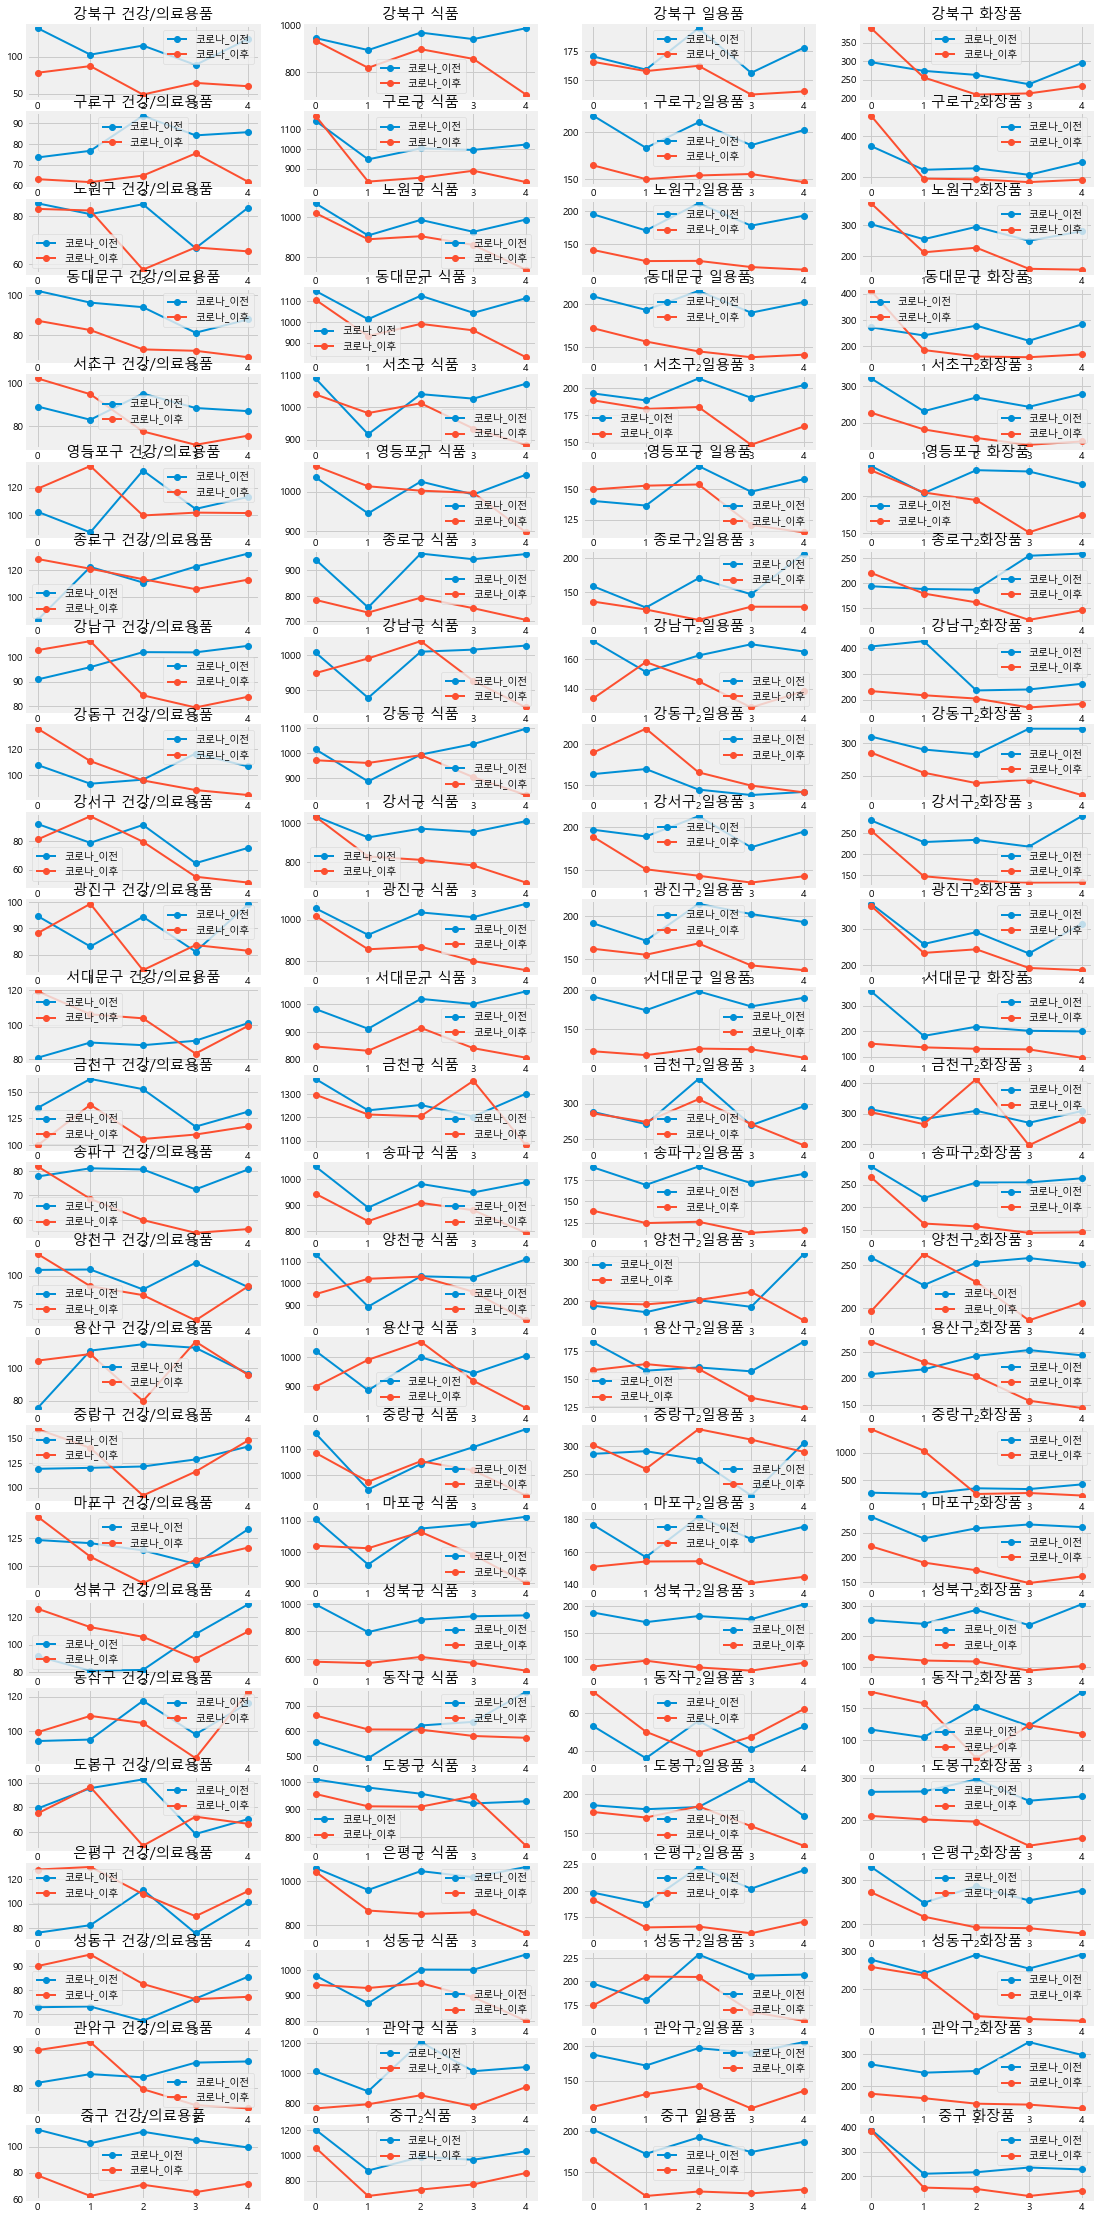

In [17]:
fig, ax = plt.subplots(25,4,figsize=(17,40))

for i in list(gu):
    index_piv = gen_pivot(index_all,"catl",i)
    index_bf = index_piv[:5]
    index_af = index_piv[12:]
    for j in range(1,5):    
        ax[list(gu).index(i)][j-1].plot(np.array(index_bf[list(index_bf.columns)[j]]),marker='o', linewidth=2,label='코로나_이전')
        ax[list(gu).index(i)][j-1].plot(np.array(index_af[list(index_af.columns)[j]]),marker='o', linewidth=2,label='코로나_이후')
        ax[list(gu).index(i)][j-1].legend()
        ax[list(gu).index(i)][j-1].set_title("{} {}".format(i,np.array(list(index_bf.columns)[j])))

In [6]:
"""
def masking(df,age,gender):
    mask1=(df['gender']==gender)
    mask2=(df['age']==age)
    data=df.loc[mask1]
    data=data.loc[mask2]
    data=data.groupby(['period','catm']).mean().reset_index()
    data_pivot=data.pivot(index='period',columns='catm',values='cgi').fillna(0)
    data_pivot_insert=pd.DataFrame(np.repeat(100,17)).T
    data_pivot_insert.columns=list(data_pivot.columns)
    data_pivot=pd.concat([data_pivot_insert, data_pivot])
    
    return data_pivot
"""